# TORCH.NN 이 실제로 무엇인가요

## MNIST 데이터 준비

In [95]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/main/_static/"
FILENAME = "mnist.pkl.gz"

if not(PATH / FILENAME).exists():
    content = requests.get(URL + FILENAME).content
    (PATH / FILENAME).open("wb").write(content)

In [96]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

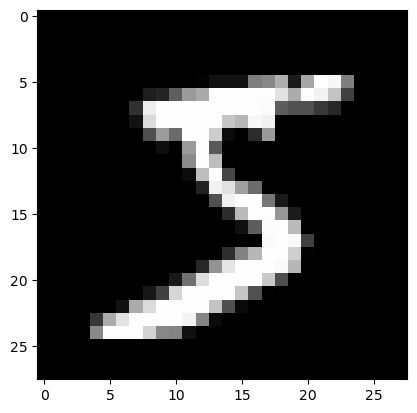

(50000, 784)


In [97]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")

try:
    import google.colab
except ImportError:
    pyplot.show()
print(x_train.shape)

In [98]:
# 텐서 변환
import torch
x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)

n, c = x_train.shape
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) <built-in method max of Tensor object at 0x7f7844831490>


## **torch.nn** 없이 신경망 만들기

Xavier initialisation 기법을 이용하여 가중치 초기화

In [99]:
import math

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

In [100]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias)

In [101]:
bs = 64 # batch_size 배치크기

xb = x_train[0:bs]
preds = model(xb)
preds[0], preds.shape
print(preds[0], preds.shape)

tensor([-2.4723, -2.6547, -2.3210, -2.0099, -2.2415, -2.2836, -2.4307, -2.4213,
        -2.1638, -2.1783], grad_fn=<SelectBackward0>) torch.Size([64, 10])


In [102]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

In [103]:
yb = y_train[0:bs]
print(loss_func(preds, yb))

tensor(2.3088, grad_fn=<NegBackward0>)


In [104]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [105]:
print(accuracy(preds, yb))

tensor(0.1094)


In [106]:
from IPython.core.debugger import set_trace

lr = 0.5
epochs = 2

for epoch in range(epochs):
    for i in range((n-1) // bs + 1):

        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

In [107]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0822, grad_fn=<NegBackward0>) tensor(1.)


## **torch.nn.functional** 사용하기

In [108]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias

In [109]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0822, grad_fn=<NllLossBackward0>) tensor(1.)


## **nn.Module** 을 이용하여 리팩토링 하기

In [110]:
from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, xb):
        return xb @ self.weights + self.bias

In [111]:
model = Mnist_Logistic()

In [112]:
print(loss_func(model(xb), yb))

tensor(2.3594, grad_fn=<NllLossBackward0>)


In [113]:
with torch.no_grad():
    weights -= weights.grad * lr
    bias -= bias.grad * lr
    weights.grad.zero_()
    bias.grad.zero_()

In [114]:
with torch.no_grad():
    for p in model.parameters(): p -= p.grad * lr
    model.zero_grad()

TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'

In [115]:
def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()

fit()

In [116]:
print(loss_func(model(xb), yb))

tensor(0.0789, grad_fn=<NllLossBackward0>)


## **nn.Linear**를 사용하여 리팩토링 하기

In [117]:
class Mnist_logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)

    def forward(self, xb):
        return self.lin(xb)

In [118]:
model = Mnist_Logistic()
print(loss_func(model(xb), yb))

tensor(2.3960, grad_fn=<NllLossBackward0>)


In [119]:
fit()

print(loss_func(model(xb), yb))

tensor(0.0814, grad_fn=<NllLossBackward0>)


## **torch.optim** 을 이용하여 리팩토링 하기

In [120]:
with torch.no_grad():
    for p in model.parameters(): p -= p.grad * lr
    model.zero_grad()

TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'

In [121]:
from torch import optim

In [122]:
def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

model, opt = get_model()
print(loss_func(model(xb), yb))

for epoch in range(epochs):
    for i in range((n-1) // bs + 1):
        start_i = i * bs
        end_i = start_i * bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(2.3345, grad_fn=<NllLossBackward0>)
tensor(0.0463, grad_fn=<NllLossBackward0>)


## **Dataset**을 이용하여 리팩토링 하기

In [123]:
from torch.utils.data import TensorDataset

In [124]:
train_ds = TensorDataset(x_train, y_train)

In [125]:
xb = x_train[start_i:end_i]
yb = y_train[start_i:end_i]

In [126]:
xb, yb = train_ds[i*bs : i*bs+bs]

In [128]:
model, opt = get_model()

for epoch in range(epochs):
    for i in range((n-1) // bs + 1):
        xb, yb = train_ds[i * bs: i * bs + bs]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0801, grad_fn=<NllLossBackward0>)


## **DataLoader**를 사용하여 리팩토링 하기

In [129]:
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

In [130]:
for i in range((n-1) // bs + 1):
    xb, yb = train_ds[i*bs : i* bs + bs]
    pred = model(xb)

In [131]:
for xb, yb in train_dl:
    pred = model(xb)

In [132]:
model, opt = get_model()

for epoch in range(epochs):
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0812, grad_fn=<NllLossBackward0>)


## 검증 추가하기

In [133]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

In [135]:
model, opt = get_model()

for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)

    print(epoch, valid_loss / len(valid_dl))

0 tensor(0.2983)
1 tensor(0.2772)


## **fit(), get_data()** 생성하기

In [137]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

In [143]:
import numpy as np

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )

        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)

In [144]:
def get_data(train_ds, valid_ds, bs):
    return(
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2)
    )

In [146]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.2974197253406048
1 0.3541534633100033


## **CNN**으로 넘어가기

In [149]:
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)

    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))

lr = 0.1

In [150]:
model = Mnist_CNN()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.37744086501598356
1 0.2849787456035614


## nn.Sequential
주어진 함수에서 **사용자 정의 레이어**를 쉽게 정의할 수 있어야합니다.

예를 들어 PyTorch에는 *view*레이어가 없으므로 우리의 신경망 용으로 만들어야합니다.

In [157]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)


def preprocess(x):
    return x.view(-1, 1, 28, 28)

In [158]:
model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.36177903790473936
1 0.24951562175750733


## **DataLoader** 감싸기

우리의 CNN은 상당히 간결하지만, MNIST에서만 작동합니다, 왜냐하면:
입력이 28*28의 긴 벡터라고 가정합니다.

최종적으로 CNN 그리드 크기는 4*4 라고 가정합니다. (이것은 우리가 사용한 평균 풀링 커널 크기 때문입니다.)

In [159]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28), y

class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)
    
    def __iter__(self):
        for b in self.dl:
            yield(self.func(*b))

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

In [160]:
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1))
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [161]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.6229401664257049
1 0.5058642290592194


## GPU 사용하기

In [162]:
print(torch.cuda.is_available())

True


In [163]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

In [164]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28).to(dev), y.to(dev)

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

In [166]:
model.to(dev)
opt= optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [167]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.4657214663028717
1 0.43765230360031127


## 마치면서
이제 PyTorch를 사용하여 다양한 유형의 모델을 학습하는 데 사용할 수 있는 일반 데이터 파이프 라인과 훈련 루프가 있습니다. 이제 모델 학습이 얼마나 간단한지 확인하려면 mnist_sample 노트북 을 살펴보세요.

물론 데이터 증강(data augmentation), 초매개변수 조정(hyperparameter tuning), 훈련과정 모니터링(monitoring training), 전이 학습(transfer learning) 등과 같이 추가하고 싶은 항목들이 많이 있을 것입니다. 이러한 기능들은 이 튜토리얼에 표시된 것과 동일한 설계 접근 방식을 사용하여 개발된 fastai 라이브러리에서 사용할 수 있으며, 모델을 더욱 발전시키려는 실무자에게 자연스러운 다음 단계를 제공합니다.

이 튜토리얼의 시작 부분에서 torch.nn, torch.optim, Dataset, 그리고 DataLoader 의 각 예제를 통해 설명하겠다고 이야기했었습니다. 이제 위의 내용들을 요약해보겠습니다:

torch.nn:

Module: 함수처럼 동작하지만, 또한 상태(state) (예를 들어, 신경망의 레이어 가중치)를 포함할 수 있는 호출 가능한 오브젝트를 생성합니다. 이는 포함된 Parameter (들)가 어떤 것인지 알고, 모든 기울기를 0으로 설정하고 가중치 업데이트 등을 위해 반복할 수 있습니다.

Parameter: Module 에 역전파 동안 업데이트가 필요한 가중치가 있음을 알려주는 텐서용 래퍼입니다. requires_grad 속성이 설정된 텐서만 업데이트 됩니다.

functional: 활성화 함수, 손실 함수 등을 포함하는 모듈 (관례에 따라 일반적으로 F 네임스페이스로 임포트 됩니다) 이고, 물론 컨볼루션 및 선형 레이어 등에 대해서 상태를 저장하지않는(non-stateful) 버전의 레이어를 포함합니다.

torch.optim: 역전파 단계에서 Parameter 의 가중치를 업데이트하는, SGD 와 같은 옵티마이저를 포함합니다.

Dataset: TensorDataset 과 같이 PyTorch와 함께 제공되는 클래스를 포함하여 __len__ 및 __getitem__ 이 있는 객체의 추상 인터페이스

DataLoader: 모든 종류의 Dataset 을 기반으로 데이터의 배치들을 출력하는 반복자(iterator)를 생성합니다.